#Calling Libraries

In [86]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from skimage import io
import pydot
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline 

# Misc
import math, time, os,gc

In [87]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Mount G-drive

In [88]:
from google.colab import drive
drive.mount('/gdrive') 

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [89]:
path = "/gdrive/MyDrive/MyFiles/"

Read Data

In [90]:
df = pd.read_csv(path+"Womens Clothing E-Commerce Reviews.csv",index_col=0)


In [91]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [92]:

print("---")
print(f"Shape of e-commerce dataset: {df.shape}")
print("---\n")

print(f"Memory Usage : {sum(df.memory_usage())/10**6} MB")   # In MB
print("-----\n")

---
Shape of e-commerce dataset: (23486, 10)
---

Memory Usage : 2.066768 MB
-----



In [93]:

print(f"Null columns in dataset:\n\n{df.isnull().sum().sort_values()}")

Null columns in dataset:

Clothing ID                   0
Age                           0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
Review Text                 845
Title                      3810
dtype: int64


In [94]:
df.dtypes
print("\n")
df.columns.values

Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

array(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'], dtype=object)

In [95]:
df.rename(columns={'Clothing ID': 'Clothing_ID','Review Text': 'Review_Text', 'Recommended IND': 'Recommended_IND' , 'Positive Feedback Count': 'Positive_Feedback_Count' , 'Division Name': 'Division_Name' , 'Department Name': 'Department_Name', 'Class Name': 'Class_Name'}, inplace=True)

In [96]:
df.columns.values

array(['Clothing_ID', 'Age', 'Title', 'Review_Text', 'Rating',
       'Recommended_IND', 'Positive_Feedback_Count', 'Division_Name',
       'Department_Name', 'Class_Name'], dtype=object)

#Data Pre-Processing

Missing Values

In [97]:

def fill_missing(dataset):
    dataset.Division_Name.fillna(value="Missing", inplace=True)
    dataset.Department_Name.fillna(value="Missing", inplace=True)
    dataset.Class_Name.fillna(value="Missing", inplace=True)
    dataset.Review_Text.fillna(value="Missing", inplace=True)
    dataset.Title.fillna(value="Missing", inplace=True)
    return (dataset)

In [98]:
df = fill_missing(df)

In [99]:
df.isnull().sum()

Clothing_ID                0
Age                        0
Title                      0
Review_Text                0
Rating                     0
Recommended_IND            0
Positive_Feedback_Count    0
Division_Name              0
Department_Name            0
Class_Name                 0
dtype: int64

In [100]:
df.head(3)

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name
0,767,33,Missing,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,Missing,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [102]:
# categorical columns
cat_columns = ['Department_Name','Division_Name','Class_Name']

#Label Encoding of categorical data

In [103]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for x in cat_columns:
    le.fit(df[x])
    df[x] = le.transform(df[x].values)

df.head()

LabelEncoder()

LabelEncoder()

LabelEncoder()

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name
0,767,33,Missing,Absolutely wonderful - silky and sexy and comf...,4,1,0,2,2,5
1,1080,34,Missing,Love this dress! it's sooo pretty. i happene...,5,1,4,0,1,3
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,0,1,3
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,1,0,14
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,0,5,0


Final look at transformed data

In [105]:
te = Tokenizer()  # Create Tokenizer() object
te.fit_on_texts(df.Review_Text.values) 

print("Transforming of text to int seq for column, 'seq_Review_Text'")
df["seq_Review_Text"] = te.texts_to_sequences(df.Review_Text.values)
print("-----\n")

Transforming of text to int seq for column, 'seq_Review_Text'
-----



In [106]:
te.fit_on_texts(df.Title.values) 

print("Transforming of text to int seq for column, 'seq_Title'") 
df["seq_Title"] = te.texts_to_sequences(df.Title.values)
print("-----\n")

Transforming of text to int seq for column, 'seq_Title'
-----



In [107]:
df.head()

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name,seq_Review_Text,seq_Title
0,767,33,Missing,Absolutely wonderful - silky and sexy and comf...,4,1,0,2,2,5,"[254, 533, 918, 3, 663, 3, 68]",[48]
1,1080,34,Missing,Love this dress! it's sooo pretty. i happene...,5,1,4,0,1,3,"[21, 7, 18, 33, 1713, 99, 2, 1323, 8, 221, 5, ...",[48]
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,0,1,3,"[2, 65, 313, 178, 1096, 12, 7, 18, 3, 51, 195,...","[158, 1835, 135, 1101]"
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,1,0,14,"[2, 21, 21, 21, 7, 631, 33, 284, 1303, 3, 789,...","[18, 293, 221]"
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,0,5,0,"[7, 80, 6, 23, 58, 8, 75, 487, 8, 1, 1158, 156...","[56, 72]"


In [108]:
MAX_REVIEW_TEXT = np.max([df.explode('seq_Review_Text')['seq_Review_Text'].max() ]
                     ) + 1
print(f"Maximum Vocabulary size in seq_Review_text is {MAX_REVIEW_TEXT}")
MAX_TITLE = np.max([df.explode('seq_Title')['seq_Title'].max() ]
                     ) + 1
print(f"Maximum Vocabulary size in seq_Title is {MAX_TITLE}")

Maximum Vocabulary size in seq_Review_text is 14848
Maximum Vocabulary size in seq_Title is 15395


In [109]:
MAX_Division_Name = df.Division_Name.max() + 1

print(f"Maximum Vocabulary size in Division_Name is {MAX_Division_Name}")

Maximum Vocabulary size in Division_Name is 4


In [110]:
MAX_Department_Name = df.Department_Name.max() + 1

print(f"Maximum Vocabulary size in Department_Name is {MAX_Department_Name}")

Maximum Vocabulary size in Department_Name is 7


In [111]:
MAX_Class_Name = df.Class_Name.max() + 1

print(f"Maximum Vocabulary size in Class_Name is {MAX_Class_Name}")

Maximum Vocabulary size in Class_Name is 21


In [112]:

MAX_Rating = df.Rating.max()
print(f"Maximum Vocabulary size in Rating is {MAX_Rating} ")

MAX_Positive_Feedback_Count = df.Positive_Feedback_Count.max()+1
print(f"Maximum Vocabulary size in Positive_Feedback_Count is {MAX_Positive_Feedback_Count} ")

MAX_Age = df.Age.max()
print(f"Maximum Vocabulary size in Age is {MAX_Age} ")

Maximum Vocabulary size in Rating is 5 
Maximum Vocabulary size in Positive_Feedback_Count is 123 
Maximum Vocabulary size in Age is 99 


In [113]:
max_Title_seq=np.max(df.seq_Title.apply(lambda x: len(x)))
print(f"Max Title seq length: {max_Title_seq}")

Max Title seq length: 12


In [114]:
max_Review_Text_seq=np.max(df.seq_Review_Text.apply(lambda x: len(x)))
print(f"Max Review Text seq length: {max_Review_Text_seq}")

Max Review Text seq length: 116


Histogram to look at distributions

In [117]:
# EMBEDDINGS MAX VALUES
MAX_REVIEW_TEXT_SEQ = 100
MAX_TITLE_SEQ = 10

In [118]:
num_col=["Age","Positive_Feedback_Count"]

In [120]:
df.head()

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name,seq_Review_Text,seq_Title
0,767,33,Missing,Absolutely wonderful - silky and sexy and comf...,4,1,0,2,2,5,"[254, 533, 918, 3, 663, 3, 68]",[48]
1,1080,34,Missing,Love this dress! it's sooo pretty. i happene...,5,1,4,0,1,3,"[21, 7, 18, 33, 1713, 99, 2, 1323, 8, 221, 5, ...",[48]
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,0,1,3,"[2, 65, 313, 178, 1096, 12, 7, 18, 3, 51, 195,...","[158, 1835, 135, 1101]"
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,1,0,14,"[2, 21, 21, 21, 7, 631, 33, 284, 1303, 3, 789,...","[18, 293, 221]"
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,0,5,0,"[7, 80, 6, 23, 58, 8, 75, 487, 8, 1, 1158, 156...","[56, 72]"


#Data Split

In [122]:
X= df.drop('Recommended_IND',axis=1)
y= df.pop('Recommended_IND')

In [123]:
X_C=X.copy()

In [124]:
y_C=y.copy()

In [132]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

 X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [135]:
X_train.shape   
X_test.shape  
X_val.shape

(14091, 11)

(4698, 11)

(4697, 11)

In [136]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14091 entries, 10786 to 5542
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing_ID              14091 non-null  int64 
 1   Age                      14091 non-null  int64 
 2   Title                    14091 non-null  object
 3   Review_Text              14091 non-null  object
 4   Rating                   14091 non-null  int64 
 5   Positive_Feedback_Count  14091 non-null  int64 
 6   Division_Name            14091 non-null  int64 
 7   Department_Name          14091 non-null  int64 
 8   Class_Name               14091 non-null  int64 
 9   seq_Review_Text          14091 non-null  object
 10  seq_Title                14091 non-null  object
dtypes: int64(7), object(4)
memory usage: 1.3+ MB


#Define a function to create a dictionary of data

In [137]:
def get_keras_data(dataset):
    X = {   
        'Review_text_in':           pad_sequences(dataset.seq_Review_Text, maxlen=MAX_REVIEW_TEXT_SEQ),                        
        'Title_in':                 pad_sequences(dataset.seq_Title, maxlen=MAX_TITLE_SEQ),       
        'Class_Name_in':            dataset.Class_Name.values,                                               
        'Department_Name_in':       dataset.Department_Name.values,                                                
        'Division_Name_in':         dataset.Division_Name.values,      
        'num_vars_in':              np.array(dataset[["Age", "Rating","Positive_Feedback_Count"]])    
    }
    return X


In [138]:

X_train = get_keras_data(X_train) 

In [139]:
X_train.keys()

dict_keys(['Review_text_in', 'Title_in', 'Class_Name_in', 'Department_Name_in', 'Division_Name_in', 'num_vars_in'])

In [140]:


X_val = get_keras_data(X_val)
X_test = get_keras_data(X_test)

#About embedding of categorical values in vector-space

In [141]:


word2vec_size = 60   
cat2vec_size = 10   
cond2vec_size = 5    

Input layers definititon

In [142]:
# SIX Inputs. At each input specify number of input-features:

review_text =            Input(shape=[X_train["Review_text_in"].shape[1]],      name="Review_text_in")           # Length of each sequence . this variable with .shape[1] is the padding length
title =       Input(shape=[X_train["Title_in"].shape[1]], name="Title_in")      # Length of each sequence
class_name =      Input(shape=[1],                             name="Class_Name_in")     # Just 1 feature. Hence shape=[1]
department_name =   Input(shape=[1],                             name="Department_Name_in")  # Just 1 feature. Hence shape=[1]
division_name =  Input(shape=[1],                             name="Division_Name_in") # Just 1 feature. Hence shape = [1]
num_vars =        Input(shape=[X_train["num_vars_in"].shape[1]],  name="num_vars_in")


In [143]:

emb_review_text =           Embedding(MAX_REVIEW_TEXT,      word2vec_size  )(review_text)               
emb_title =      Embedding(MAX_TITLE,      word2vec_size  )(title)

emb_class_name =     Embedding(MAX_Class_Name,     cat2vec_size  )(class_name)
emb_department_name =  Embedding(MAX_Department_Name,  cat2vec_size  )(department_name)
emb_division_name = Embedding(MAX_Division_Name, cat2vec_size )(division_name)

In [144]:
rnn_layer2 = GRU(8) (emb_title)         
rnn_layer1 = GRU(16) (emb_review_text)    

In [145]:
print(f"emb_class_name: {emb_class_name.shape}")           
print(f"emb_department_name: {emb_department_name.shape}")      
print(f"emb_division_name: {emb_division_name.shape}")    
print(f"rnn_layer1: {rnn_layer1.shape}")                    
print(f"rnn_layer2: {rnn_layer2.shape}")                   

emb_class_name: (None, 1, 10)
emb_department_name: (None, 1, 10)
emb_division_name: (None, 1, 10)
rnn_layer1: (None, 16)
rnn_layer2: (None, 8)


In [147]:

main_l = concatenate(
                        [
                          Flatten() (emb_class_name),
                          Flatten() (emb_department_name),
                          Flatten() (emb_division_name),
                          rnn_layer1,       
                          rnn_layer2,
                          num_vars          
                        ]
                      )

In [148]:
# Level of dropouts: 10%
dr_r = 0.1   

# Add classification layer
main_l = Dense(128) (main_l)
main_l = Dropout(dr_r)(main_l)
main_l = Dense(64) (main_l)
main_l = Dropout(dr_r) (main_l)

In [149]:

output = Dense(1, activation="linear") (main_l)

In [150]:
# Create model now
model = Model(inputs = [review_text,title,class_name,department_name,division_name,num_vars], outputs = [output])

In [151]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Class_Name_in (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 Department_Name_in (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 Division_Name_in (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 Review_text_in (InputLayer)    [(None, 100)]        0           []                           

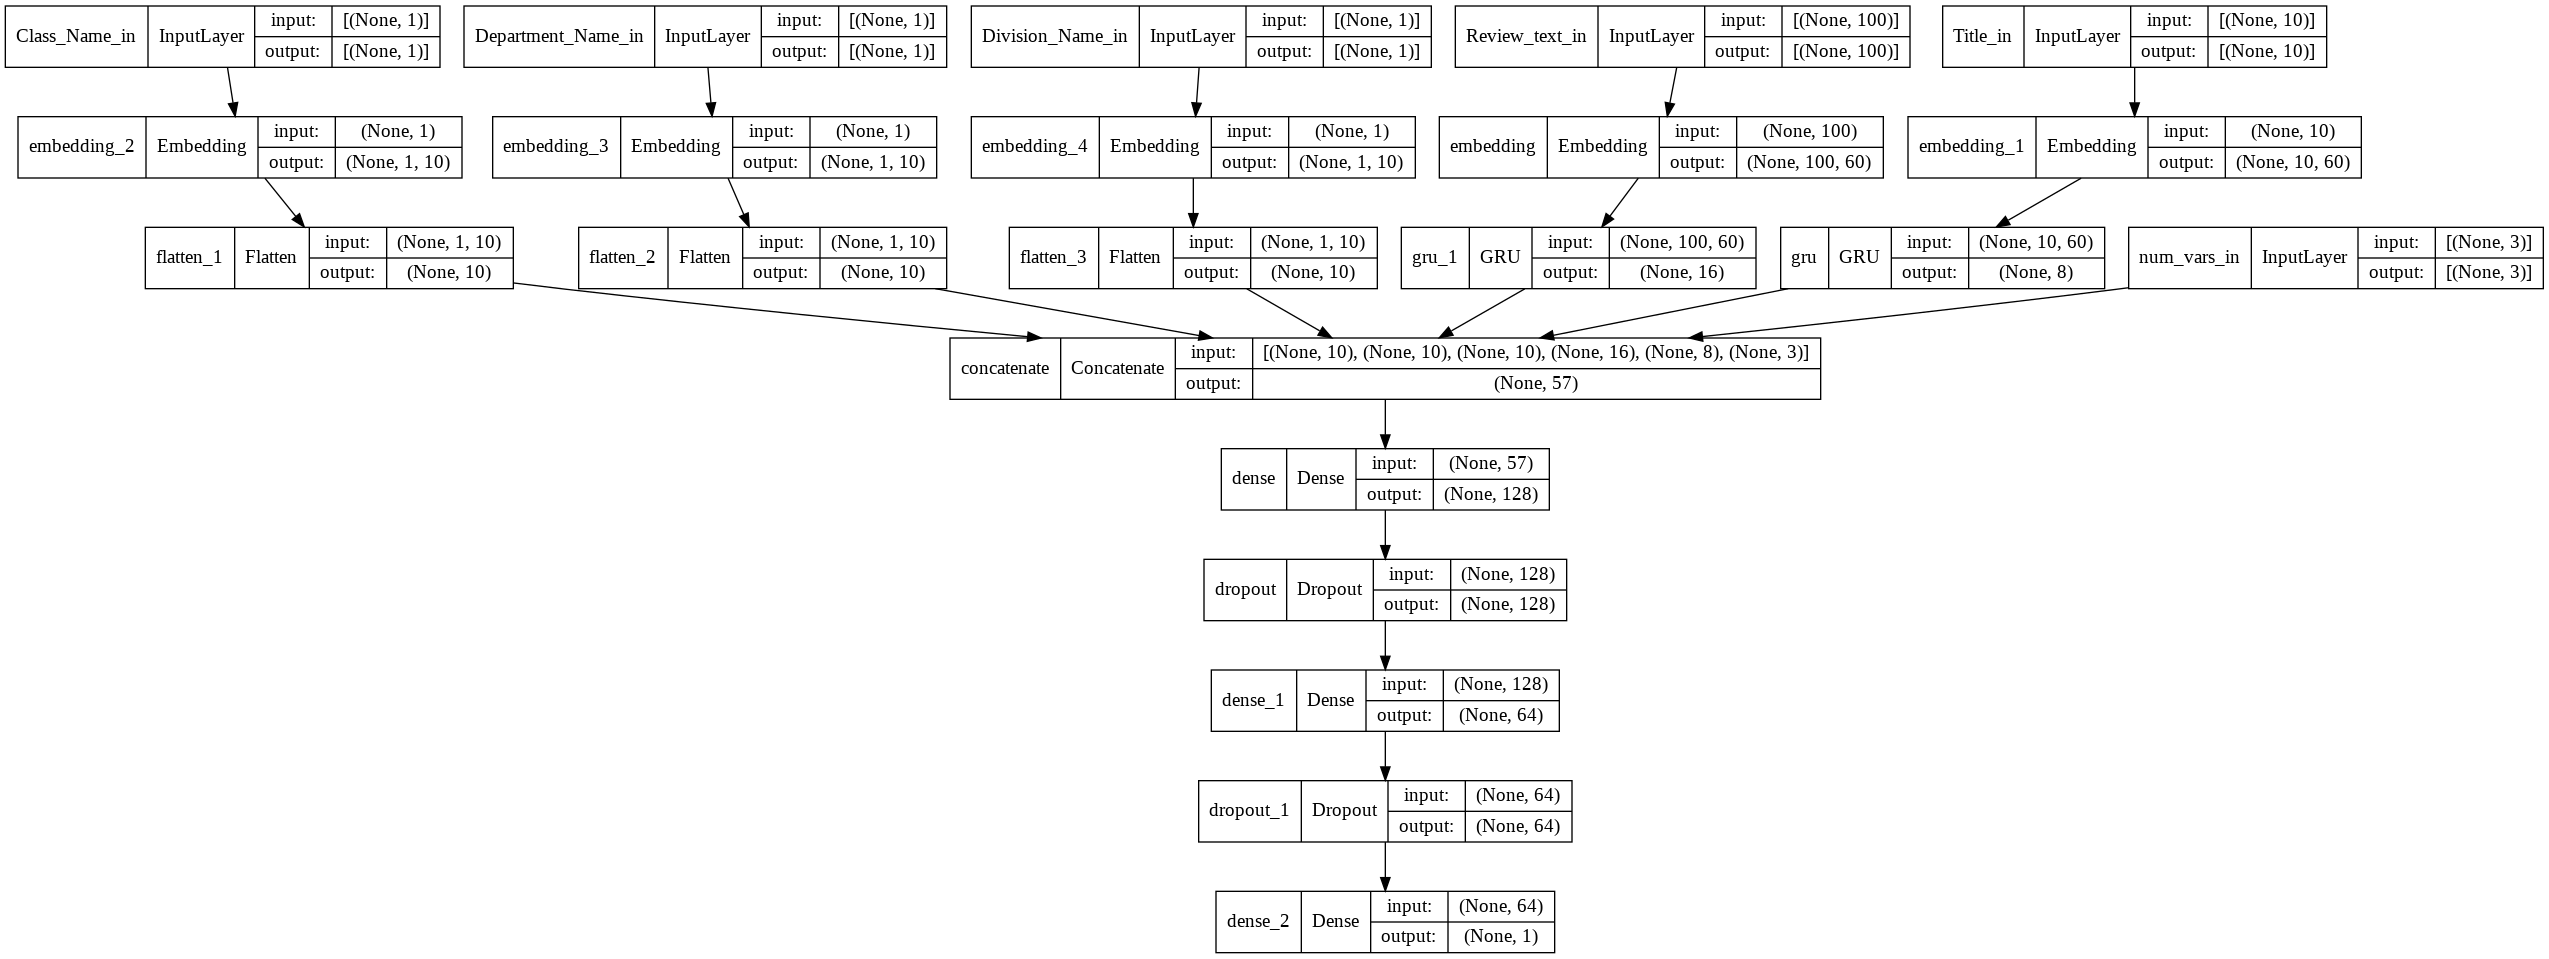

In [152]:
plot_model(model, show_shapes= True)

In [154]:
model.compile(loss = "mean_squared_error", optimizer='adam')  
start = time.time()
history = model.fit(
                    X_train,
                    y_train,
                    epochs = 7,
                    validation_data=(X_val, y_val),
                    verbose = 1
                    )
end = time.time()
print((end-start)/60)   

Epoch 1/7
441/441 [==============================] - 36s 61ms/step - loss: 3.1384 - val_loss: 0.1115
Epoch 2/7
441/441 [==============================] - 26s 59ms/step - loss: 0.3269 - val_loss: 0.1141
Epoch 3/7
441/441 [==============================] - 35s 79ms/step - loss: 0.1566 - val_loss: 0.0694
Epoch 4/7
441/441 [==============================] - 26s 59ms/step - loss: 0.1119 - val_loss: 0.0568
Epoch 5/7
441/441 [==============================] - 26s 59ms/step - loss: 0.0997 - val_loss: 0.0628
Epoch 6/7
441/441 [==============================] - 27s 61ms/step - loss: 0.0834 - val_loss: 0.0576
Epoch 7/7
441/441 [==============================] - 28s 64ms/step - loss: 0.0805 - val_loss: 0.0635
3.4124964555104573


In [155]:
model.evaluate(X_test,y_test)  

147/147 [==============================] - 2s 14ms/step - loss: 0.0640


0.06402435898780823